In [1]:
import pandas as pd
import asyncio
import os
import sys

notebook_dir = os.getcwd()  

emotions_dir   = os.path.abspath(os.path.join(notebook_dir, "..", "..", "emotions"))

context_dir = os.path.abspath(os.path.join(notebook_dir, "..", "..", "context"))

evaluation_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

sentiment_evaluation_dir = os.path.join(evaluation_dir, "sentiment")

for d in (emotions_dir, context_dir, evaluation_dir, sentiment_evaluation_dir):
    if d not in sys.path:
        sys.path.insert(0, d)

from song_evaluator import run_evaluation
from emotions import emotions_labels
from context import get_context_embedding
from utils import get_emotional_embedding, get_lyrics

c:\Users\Lucio\Documents\entornos\env3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RESULTS_STORAGE_PATH = "songs_results"
CSV_PROMPTS_PATH = "../sentiment/eval_prompts.csv"
IDX = {lbl: i for i, lbl in enumerate(emotions_labels)}

## Recomend songs

In [ ]:
df = pd.read_csv(CSV_PROMPTS_PATH)

df["emotional_embeddings"] = df["text"].apply(get_emotional_embedding)
df["context_embeddings"] = df["text"].apply(get_context_embedding)
print(df.head())

In [ ]:
df["lyrics_predictions"] = df.apply(
    lambda row: get_lyrics(
        row["emotional_embeddings"],
        row["context_embeddings"],
        weight_emotion=0.4,
        weight_context=0.6,
    ),
    axis=1,
)

In [ ]:
#save df with text and predictions only
df[["text", "lyrics_predictions"]].to_csv(os.path.join(RESULTS_STORAGE_PATH, "lyrics_predictions.csv"), index=False)

## Evaluator

In [3]:
path = os.path.join(RESULTS_STORAGE_PATH, "lyrics_predictions.csv")
df = pd.read_csv(path)

In [4]:
#save evaluated_df to obtain the scores
evaluated_df = await run_evaluation(df)
evaluated_df.to_csv(os.path.join(RESULTS_STORAGE_PATH, "evaluated_lyrics_predictions.csv"), index=False)

## Evaluation

In [5]:
path = os.path.join(RESULTS_STORAGE_PATH,  "evaluated_lyrics_predictions.csv")
df = pd.read_csv(path)

In [7]:
#Hay canciones que pueden no ser evaluadas por el filtro de contenido de OpenAI.
df_filtered = df[df["rationale"].str.contains("The song was filtered out by the content filter")]
df_not_filtered = df[~df["rationale"].str.contains("The song was filtered out by the content filter")]

print("Filtered songs: ", len(df_filtered))
print("Not filtered songs: ", len(df_not_filtered))

Filtered songs:  7
Not filtered songs:  74


,emotional,contextual,coherence,overall
count,74.00,74.00,74.00,74.00
mean,2.66,2.19,2.55,2.42
std,1.56,1.64,1.07,1.34
min,0.00,0.00,0.00,0.00
25%,1.00,1.00,2.00,1.00
50%,3.00,2.00,3.00,2.48
75%,4.00,4.00,3.00,3.70
max,5.00,5.00,5.00,4.70


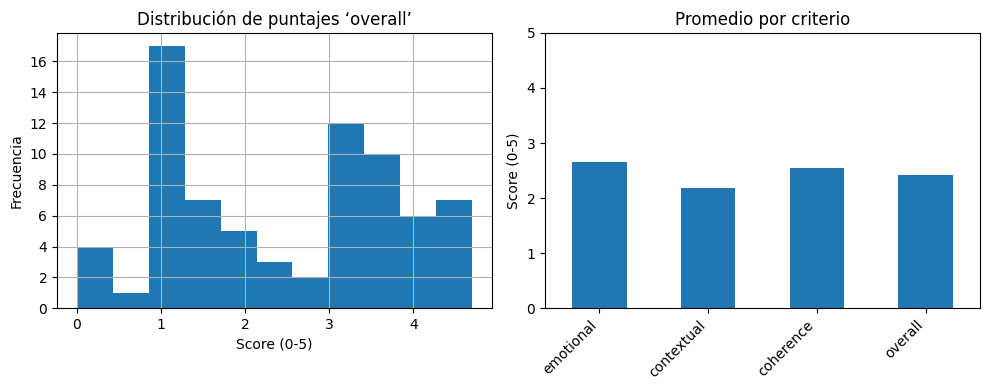

,text,lyrics_predictions,score
16,"Since my grandmother passed away, the house fe...",stop here across the street to your right that...,4.7
18,I adore you with all my heart.,in you i find my home completely known complet...,4.7
32,Take your coat; it's chilly and I don't want y...,put on your cap and your coat come on come on ...,4.3
67,I just found out my best friend is flying in f...,i got a big surprise when i saw you smile i ne...,4.3
76,I just found an old photo of my childhood home...,there s an old kodak camera in my dresser draw...,4.3


,text,lyrics_predictions,score
7,How do black holes really work?,my creator my creator my creator my creator ya...,0.00
11,The smell of rotten food was unbearable.,yeah yeah when i walk on by i smell like shit ...,0.00
28,Watching the penguin slide on its belly cracke...,i saw the creature fall into the swamp from wh...,0.00
37,Leaving dirty dishes in the sink overnight isn...,we cannot continue this unauthorized content u...,0.00
2,I can't believe you deleted all my work withou...,there s no one anywhere waiting for you i do n...,0.67


In [8]:
import matplotlib.pyplot as plt

# 2. Muestra estadísticas descriptivas en pantalla
stats = df_not_filtered[[
    "emotional","contextual","coherence","overall"
]].describe().round(2)
display(stats)          # En Jupyter se ve como tabla

# 3. Crea una única figura con dos gráficos
plt.figure(figsize=(10, 4))

# 3-a Histograma de puntajes globales
plt.subplot(1, 2, 1)
df_not_filtered["overall"].hist(bins=11)
plt.title("Distribución de puntajes ‘overall’")
plt.xlabel("Score (0-5)")
plt.ylabel("Frecuencia")

# 3-b Barra de promedios por criterio
plt.subplot(1, 2, 2)
(df_not_filtered[[
    "emotional", "contextual", "coherence", "overall"
 ]].mean()
 ).plot(kind="bar")
plt.ylim(0, 5)
plt.title("Promedio por criterio")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Score (0-5)")

plt.tight_layout()
plt.show()

# 4. Top y bottom 5 songs recommendations
display(df_not_filtered.sort_values("overall", ascending=False)
          .head(5)[["text", "lyrics_predictions", "overall"]]
          .rename(columns={"overall": "score"}))

display(df_not_filtered.sort_values("overall", ascending=True)
          .head(5)[["text", "lyrics_predictions", "overall"]]
          .rename(columns={"overall": "score"}))
